# Experiment 1: Distribution Shift Under Different System Prompts

**Goal:** Measure how different system prompts change the output distribution for the SAME user queries.

**Setup:**
- Fixed test prompts (30 prompts across 6 categories)
- Variable: 16 different system prompts
- Metrics: KL divergence, JS divergence, entropy, top-k overlap

**Key Questions:**
- Which system prompts cause the largest distribution shifts?
- Are some prompt categories more sensitive to system prompts?
- Do certain system prompts cluster together in their effects?

In [ ]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")
print(f"Python path includes: {sys.path[:3]}")

Working directory: /content/LLM-Instruction-Understanding
Python path includes: ['/content/LLM-Instruction-Understanding', '/content', '/env/python']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

In [ ]:
model = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
print(f"Testing {len(ALL_TEST_PROMPTS)} prompts × {len(SYSTEM_PROMPTS)} system prompts")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Model loaded on cuda
Testing 30 prompts × 16 system prompts


## 1. Collect Distributions

In [ ]:
def collect_distributions(model, test_prompts, system_prompts):
    results = []
    total = len(test_prompts) * len(system_prompts)
    pbar = tqdm(total=total, desc="Collecting distributions")
    
    for test in test_prompts:
        for sys_name, sys_info in system_prompts.items():
            full_prompt = build_chat_prompt(sys_info["text"], test["prompt"], model.tokenizer)
            dist = model.get_next_token_distribution(full_prompt, top_k=100)
            
            # top_tokens is list of (token, prob) tuples
            top_tokens = [t[0] for t in dist["top_tokens"]]
            top_probs = [t[1] for t in dist["top_tokens"]]
            
            results.append({
                "test_id": test["id"],
                "test_prompt": test["prompt"],
                "category": test["category"],
                "system_prompt": sys_name,
                "entropy": dist["entropy"],
                "top_token": top_tokens[0] if top_tokens else "",
                "top_prob": top_probs[0] if top_probs else 0,
                "top_5_tokens": top_tokens[:5],
                "full_probs": dist["full_probs"]
            })
            pbar.update(1)
    pbar.close()
    return results

all_distributions = collect_distributions(model, ALL_TEST_PROMPTS, SYSTEM_PROMPTS)

## 2. Calculate Divergences from Baseline

In [ ]:
def calculate_divergences(distributions, baseline="none"):
    by_test = {}
    for d in distributions:
        if d["test_id"] not in by_test:
            by_test[d["test_id"]] = {}
        by_test[d["test_id"]][d["system_prompt"]] = d
    
    divergences = []
    for test_id, sys_dists in by_test.items():
        if baseline not in sys_dists:
            continue
        base = sys_dists[baseline]
        
        for sys_name, sys_dist in sys_dists.items():
            if sys_name == baseline:
                continue
            
            kl = DistributionMetrics.kl_divergence(base["full_probs"], sys_dist["full_probs"])
            js = DistributionMetrics.jensen_shannon(base["full_probs"], sys_dist["full_probs"])
            overlap = DistributionMetrics.top_k_overlap(base["top_5_tokens"], sys_dist["top_5_tokens"])
            
            divergences.append({
                "test_id": test_id, "category": base["category"], "system_prompt": sys_name,
                "kl_divergence": kl, "js_divergence": js, "top_5_overlap": overlap,
                "entropy_change": sys_dist["entropy"] - base["entropy"],
                "top_token_changed": base["top_token"] != sys_dist["top_token"]
            })
    return pd.DataFrame(divergences)

divergence_df = calculate_divergences(all_distributions)

## 3. System Prompt Impact Analysis

In [ ]:
sys_impact = divergence_df.groupby('system_prompt').agg({
    'js_divergence': ['mean', 'std'],
    'entropy_change': 'mean',
    'top_token_changed': 'mean'
}).round(4)
sys_impact.columns = ['js_mean', 'js_std', 'entropy_change', 'top_change_rate']
sys_impact = sys_impact.sort_values('js_mean', ascending=False)
print(sys_impact)

                  js_mean  js_std  entropy_change  top_change_rate
system_prompt                                                     
cautious              inf     NaN             NaN           0.3333
concise               inf     NaN             NaN           0.1667
confident             inf     NaN             NaN           0.4000
cot                   inf     NaN             NaN           0.3333
creative              inf     NaN             NaN           0.2000
expert                inf     NaN             NaN           0.2000
formal                inf     NaN             NaN           0.2000
friendly              inf     NaN             NaN           0.2000
helpful_detailed      inf     NaN             NaN           0.2333
minimal               inf     NaN             NaN           0.2000
safety                inf     NaN             NaN           0.2667
scientist             inf     NaN             NaN           0.3333
structured            inf     NaN             NaN           0.

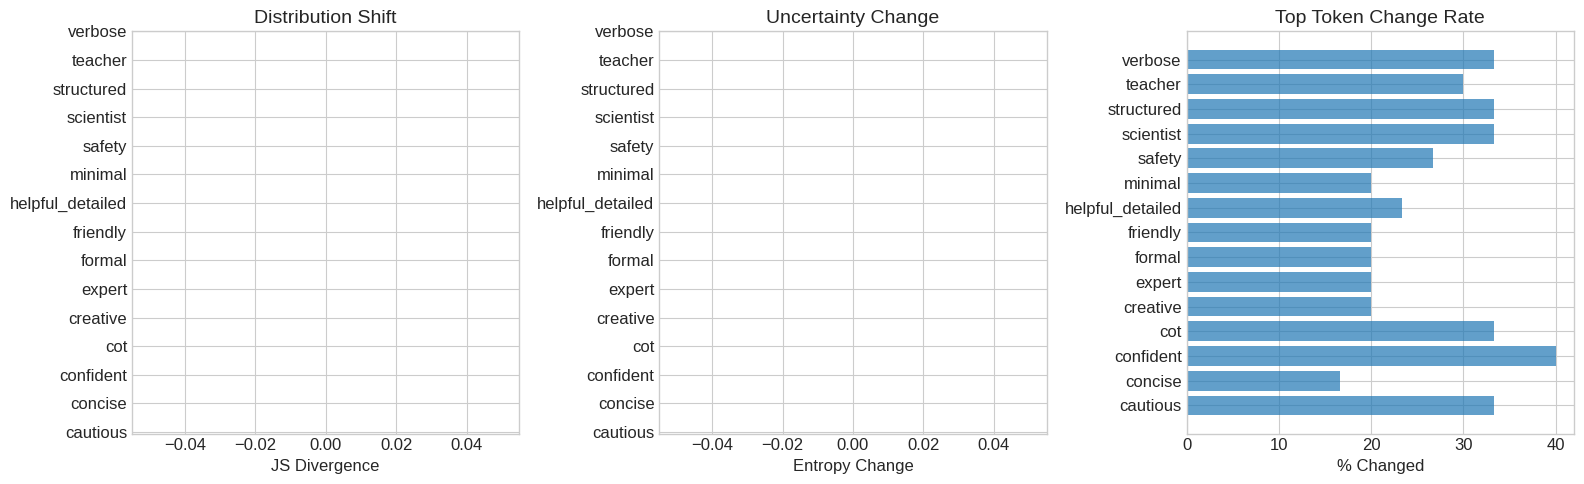

In [ ]:
import os
os.makedirs('../results', exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

s = sys_impact.sort_values('js_mean')
axes[0].barh(range(len(s)), s['js_mean'], xerr=s['js_std'], capsize=3, alpha=0.7)
axes[0].set_yticks(range(len(s))); axes[0].set_yticklabels(s.index)
axes[0].set_xlabel('JS Divergence'); axes[0].set_title('Distribution Shift')

colors = ['green' if x > 0 else 'red' for x in s['entropy_change']]
axes[1].barh(range(len(s)), s['entropy_change'], color=colors, alpha=0.7)
axes[1].set_yticks(range(len(s))); axes[1].set_yticklabels(s.index)
axes[1].set_xlabel('Entropy Change'); axes[1].set_title('Uncertainty Change')

axes[2].barh(range(len(s)), s['top_change_rate']*100, alpha=0.7)
axes[2].set_yticks(range(len(s))); axes[2].set_yticklabels(s.index)
axes[2].set_xlabel('% Changed'); axes[2].set_title('Top Token Change Rate')

plt.tight_layout()
plt.savefig('../results/exp1_system_prompt_impact.png', dpi=150)
plt.show()

## 4. Category Sensitivity

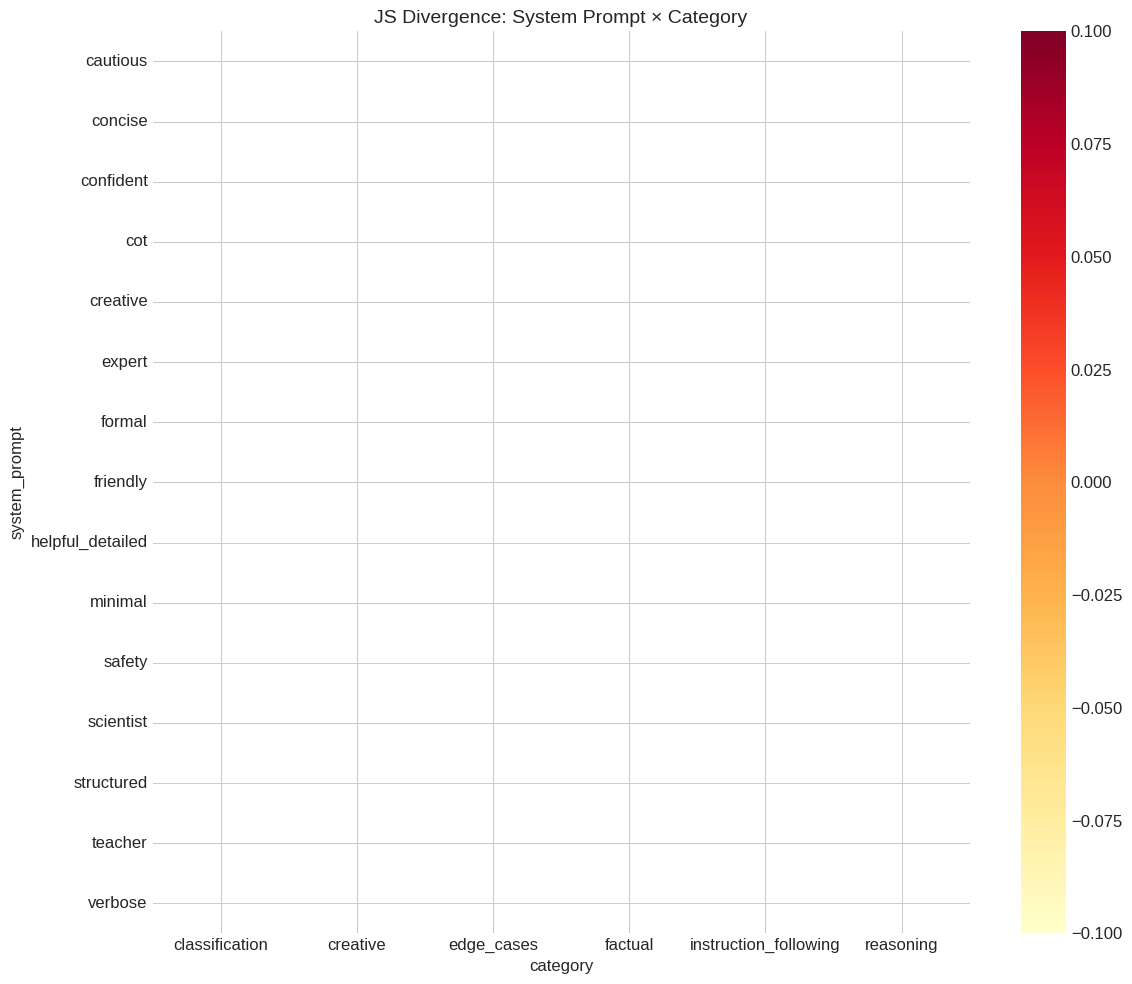

In [ ]:
pivot = divergence_df.pivot_table(values='js_divergence', index='system_prompt', columns='category', aggfunc='mean')

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
ax.set_title('JS Divergence: System Prompt × Category')
plt.tight_layout()
plt.savefig('../results/exp1_heatmap.png', dpi=150)
plt.show()

In [ ]:
# Save
import json
with open('../results/exp1_results.json', 'w') as f:
    json.dump({"system_impact": sys_impact.to_dict(), "pivot": pivot.to_dict()}, f, indent=2, default=float)
print("Saved.")

Saved.
